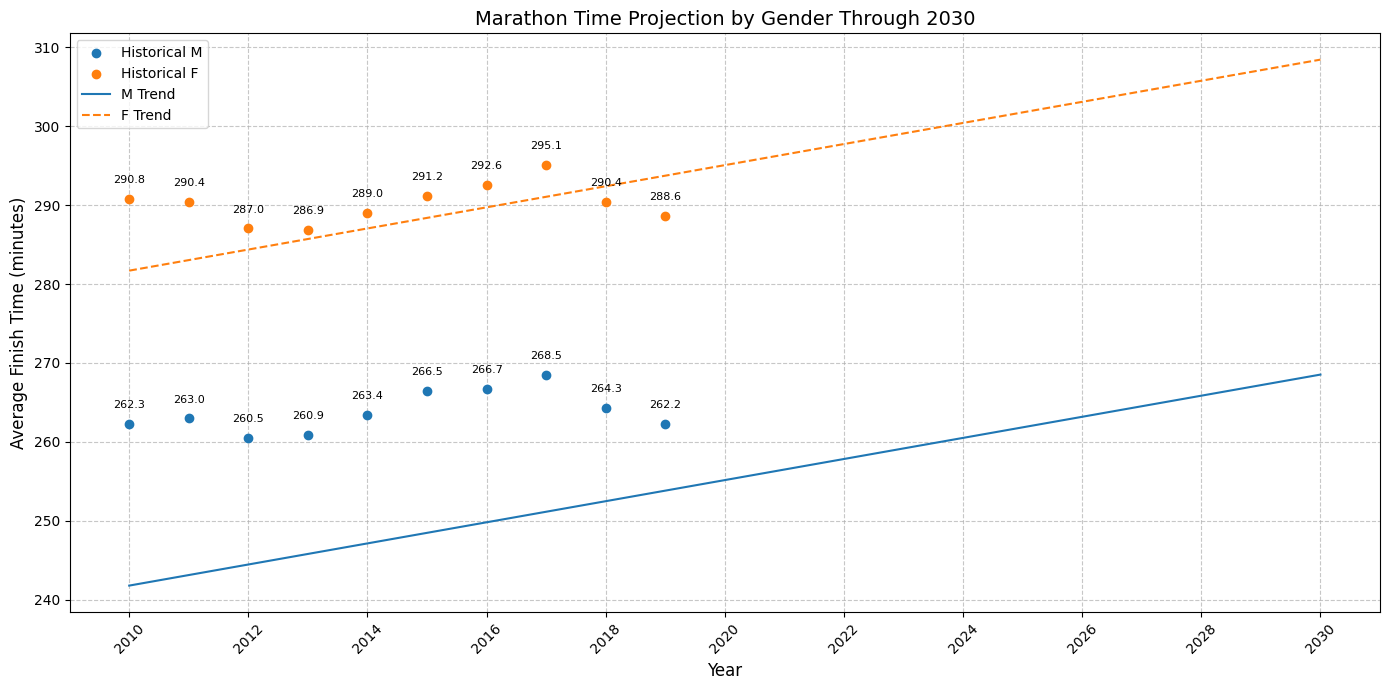


Future Projections:
Gender       F       M
Year                  
2020    4h 55m  4h 15m
2021    4h 56m  4h 16m
2022    4h 57m  4h 17m
2023    4h 59m  4h 19m
2024     5h 0m  4h 20m
2025     5h 1m  4h 21m
2026     5h 3m  4h 23m
2027     5h 4m  4h 24m
2028     5h 5m  4h 25m
2029     5h 7m  4h 27m
2030     5h 8m  4h 28m

Model Performance Metrics:
R² score: 0.977 (1.0 is perfect)
Mean Absolute Error: 1.64 minutes


In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age - FIXED VERSION
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical data points
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines
for gender in ['M', 'F']:
    # Historical + future years
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])

    # Create prediction data for this gender
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)

    # Plot line
    line_style = '-' if gender == 'M' else '--'
    plt.plot(all_years, preds, label=f'{gender} Trend', linestyle=line_style)

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Add data labels
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+2,
             f"{row['Finish_Mins']:.1f}",
             ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print future predictions
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

feature_names = model.named_steps['preprocessor'].get_feature_names_out()

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")

DIAGNOSTICS: TRAINING THE MODEL!!!!!

Test R²: 0.942  (Trust this more than training R²)
Test MAE: 2.35 mins
Cross-validated R²: 0.930 (±0.059)
Cross-validated MAE: 2.85 mins (±1.41)


Text(0.5, 1.0, 'Residual Plot')

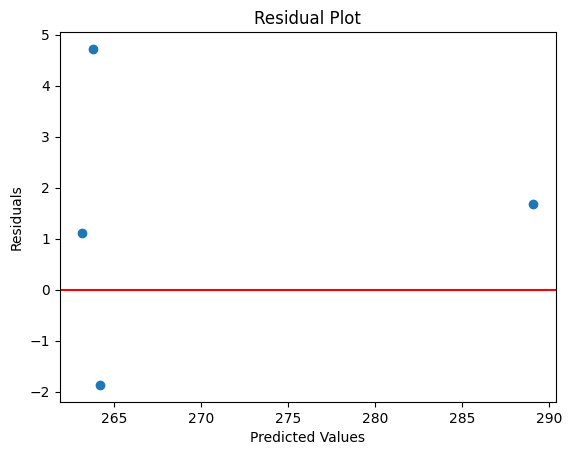

In [96]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age - FIXED VERSION
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']
# Split data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Train on training set only
model.fit(X_train, y_train)

# Evaluate on unseen test data
test_r2 = model.score(X_test, y_test)
test_preds = model.predict(X_test)
test_mae = np.mean(np.abs(y_test - test_preds))

print(f"Test R²: {test_r2:.3f}  (Trust this more than training R²)")
print(f"Test MAE: {test_mae:.2f} mins")

# 5-fold cross-validation
cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
cv_mae = -cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')

print(f"Cross-validated R²: {cv_r2.mean():.3f} (±{cv_r2.std():.3f})")
print(f"Cross-validated MAE: {cv_mae.mean():.2f} mins (±{cv_mae.std():.2f})")
# Plotting the residuals
residuals = y_test - model.predict(X_test)
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions for future years (both genders)
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# For the combined trend prediction (all genders, no gender distinction)
# Aggregate the data across both genders for a combined prediction
combined_data = df.groupby('Year')[['Finish_Mins', 'Age']].mean().reset_index()

# Prepare combined data for prediction (ignore Gender for combined)
X_combined = combined_data[['Year', 'Age']]
y_combined = combined_data['Finish_Mins']

# Make predictions for combined average finish times
combined_predictions = model.predict(X_combined)
combined_data['Predicted_Mins'] = combined_predictions

# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical data points for each gender
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines for each gender
for gender in ['M', 'F']:
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)
    line_style = '-' if gender == 'M' else '--'
    plt.plot(all_years, preds, label=f'{gender} Trend', linestyle=line_style)

# Plot combined average trend line (for both genders)
plt.plot(combined_data['Year'], combined_data['Predicted_Mins'], label='Combined Average Trend', linestyle='-', color='red')

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender and Overall Average Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Add data labels for historical data
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+2,
             f"{row['Finish_Mins']:.1f}",
             ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print future predictions for both genders and combined
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

# Print combined future projections (all genders)
print("\nCombined Future Projections (All Genders):")
combined_predictions_fut = model.predict(future_data[['Year', 'Age']])
for year, prediction in zip(future_years, combined_predictions_fut):
    print(f"Year {year}: {int(prediction // 60)}h {int(prediction % 60)}m")

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")



ValueError: columns are missing: {'Gender'}

ew

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])  # Now including Gender

# Handle negative ages
mean_age = int(df[df['Age'] >= 0]['Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age
yearly_gender_avg = df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']].mean().reset_index()

# Create modeling pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('gender', OneHotEncoder(), ['Gender'])  # Convert gender to numerical
    ],
    remainder='passthrough'  # Keep Year and Age as-is
)

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Prepare data
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']

# Train model
model.fit(X, y)

# Predict for future years (2020-2030)
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()  # Average of last year's genders

future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Create future DataFrames for both genders
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M']*len(future_years) + ['F']*len(future_years)
})

# Make predictions for future years (both genders)
future_predictions = model.predict(future_data)
future_data['Predicted_Mins'] = future_predictions

# Generate predictions for historical data too
historical_predictions = model.predict(X)
yearly_gender_avg['Predicted_Mins'] = historical_predictions

# For the combined trend prediction (all genders, no gender distinction)
# Aggregate the data across both genders for a combined prediction
combined_data = df.groupby('Year')[['Finish_Mins', 'Age']].mean().reset_index()

# Prepare combined data for prediction (this time we do not need Gender)
X_combined = combined_data[['Year', 'Age']]  # Do not include 'Gender' here
y_combined = combined_data['Finish_Mins']

# Make predictions for combined average finish times
combined_predictions = model.named_steps['regressor'].predict(X_combined)  # Directly use the regressor
combined_data['Predicted_Mins'] = combined_predictions

# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical data points for each gender
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(yearly_gender_avg.loc[mask, 'Year'],
                yearly_gender_avg.loc[mask, 'Finish_Mins'],
                label=f'Historical {gender}', zorder=3)

# Plot regression lines for each gender
for gender in ['M', 'F']:
    all_years = np.concatenate([yearly_gender_avg['Year'].unique(), future_years])
    pred_data = pd.DataFrame({
        'Year': all_years,
        'Age': last_age + 0.5 * (all_years - last_year),
        'Gender': gender
    })
    preds = model.predict(pred_data)
    line_style = '-' if gender == 'M' else '--'
    plt.plot(all_years, preds, label=f'{gender} Trend', linestyle=line_style)

# Plot combined average trend line (for both genders)
plt.plot(combined_data['Year'], combined_data['Predicted_Mins'], label='Combined Average Trend', linestyle='-', color='red')

# Add formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender and Overall Average Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Add data labels for historical data
for _, row in yearly_gender_avg.iterrows():
    plt.text(row['Year'], row['Finish_Mins']+2,
             f"{row['Finish_Mins']:.1f}",
             ha='center', fontsize=8)

plt.tight_layout()
plt.show()

# Print future predictions for both genders and combined
print("\nFuture Projections:")
print(future_data.groupby(['Year', 'Gender'])['Predicted_Mins'].agg(
    lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m"
).unstack())

# Print combined future projections (all genders)
print("\nCombined Future Projections (All Genders):")
combined_predictions_fut = model.named_steps['regressor'].predict(future_data[['Year', 'Age']])
for year, prediction in zip(future_years, combined_predictions_fut):
    print(f"Year {year}: {int(prediction // 60)}h {int(prediction % 60)}m")

# Calculate and print metrics
r2 = model.score(X, y)
y_pred = model.predict(X)
mae = np.mean(np.abs(y - y_pred))

print(f"\nModel Performance Metrics:")
print(f"R² score: {r2:.3f} (1.0 is perfect)")
print(f"Mean Absolute Error: {mae:.2f} minutes")


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/validation.py:2740: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


ValueError: X has 2 features, but LinearRegression is expecting 4 features as input.

mode shit

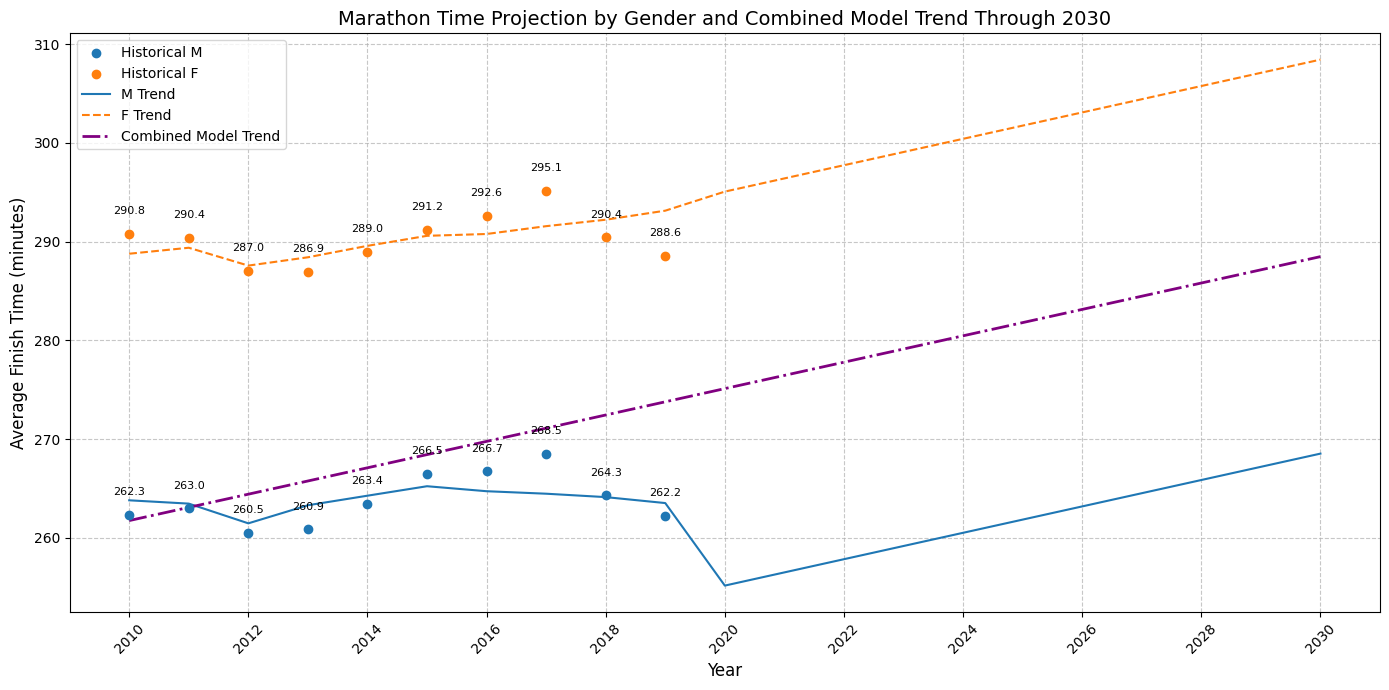


Future Projections by Gender:
Gender       F       M
Year                  
2020    4h 55m  4h 15m
2021    4h 56m  4h 16m
2022    4h 57m  4h 17m
2023    4h 59m  4h 19m
2024     5h 0m  4h 20m
2025     5h 1m  4h 21m
2026     5h 3m  4h 23m
2027     5h 4m  4h 24m
2028     5h 5m  4h 25m
2029     5h 7m  4h 27m
2030     5h 8m  4h 28m

Combined Future Projections (Model Average):
Year 2020: 4h 35m
Year 2021: 4h 36m
Year 2022: 4h 37m
Year 2023: 4h 39m
Year 2024: 4h 40m
Year 2025: 4h 41m
Year 2026: 4h 43m
Year 2027: 4h 44m
Year 2028: 4h 45m
Year 2029: 4h 47m
Year 2030: 4h 48m


InvalidParameterError: The 'y_true' parameter of r2_score must be an array-like. Got np.int64(2030) instead.

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load and clean data
df = pd.read_csv('/Users/megantrapanese/Dropbox/MARATHON_DATA/data/2019_Fall_Results/Results.csv')
df = df.dropna(subset=['Year', 'Finish', 'Age', 'Gender'])

# Handle negative ages
mean_age = int(df.loc[df['Age'] >= 0, 'Age'].mean())
df.loc[df['Age'] < 0, 'Age'] = mean_age

# Convert finish time to minutes
df['Finish_Mins'] = df['Finish'] / 60

# Aggregate by Year, Gender, and Age
yearly_gender_avg = (
    df.groupby(['Year', 'Gender'])[['Finish_Mins', 'Age']]
      .mean()
      .reset_index()
)

# Build pipeline
preprocessor = ColumnTransformer(
    [('gender', OneHotEncoder(), ['Gender'])],
    remainder='passthrough'
)
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Train model on gender-specific averages
X = yearly_gender_avg[['Year', 'Age', 'Gender']]
y = yearly_gender_avg['Finish_Mins']
model.fit(X, y)

# Set up future years
last_year = yearly_gender_avg['Year'].max()
last_age = yearly_gender_avg['Age'].mean()
future_years = np.arange(last_year + 1, 2031)
future_ages = last_age + 0.5 * (future_years - last_year)

# Prepare future DataFrame for M & F
future_data = pd.DataFrame({
    'Year': np.tile(future_years, 2),
    'Age': np.tile(future_ages, 2),
    'Gender': ['M'] * len(future_years) + ['F'] * len(future_years)
})
future_data['Predicted_Mins'] = model.predict(future_data)

# Historical predictions
yearly_gender_avg['Predicted_Mins'] = model.predict(X)

# --- PLOTTING ---
plt.figure(figsize=(14, 7))

# Scatter historical by gender
for gender in ['M', 'F']:
    mask = yearly_gender_avg['Gender'] == gender
    plt.scatter(
        yearly_gender_avg.loc[mask, 'Year'],
        yearly_gender_avg.loc[mask, 'Finish_Mins'],
        label=f'Historical {gender}',
        zorder=3
    )

# Plot regression lines with correct ages for historical & projected years
for gender in ['M', 'F']:
    years = np.array(sorted(set(yearly_gender_avg['Year']).union(set(future_years))))
    ages = []
    for y in years:
        if y <= last_year:
            ages.append(
                yearly_gender_avg.loc[
                    (yearly_gender_avg['Year'] == y) &
                    (yearly_gender_avg['Gender'] == gender),
                    'Age'
                ].values[0]
            )
        else:
            ages.append(last_age + 0.5 * (y - last_year))

    pred_df = pd.DataFrame({
        'Year': years,
        'Age': ages,
        'Gender': [gender] * len(years)
    })
    preds = model.predict(pred_df)
    style = '-' if gender == 'M' else '--'
    plt.plot(years, preds, label=f'{gender} Trend', linestyle=style)

# --- COMBINED MODEL TREND (average of M & F predictions) ---
all_years = np.array(sorted(set(yearly_gender_avg['Year']).union(set(future_years))))
combined_pred_data = pd.DataFrame({
    'Year': np.tile(all_years, 2),
    'Age': last_age + 0.5 * (np.tile(all_years, 2) - last_year),
    'Gender': ['M'] * len(all_years) + ['F'] * len(all_years)
})
combined_pred_data['Predicted_Mins'] = model.predict(combined_pred_data)
combined_trend = combined_pred_data.groupby('Year', as_index=False)['Predicted_Mins'].mean()
plt.plot(
    combined_trend['Year'],
    combined_trend['Predicted_Mins'],
    label='Combined Model Trend',
    linestyle='-.',
    linewidth=2,
    color='purple'
)

# Formatting
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Finish Time (minutes)', fontsize=12)
plt.title('Marathon Time Projection by Gender and Combined Model Trend Through 2030', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(min(yearly_gender_avg['Year']), 2031, 2), rotation=45)

# Data labels for historical
for _, row in yearly_gender_avg.iterrows():
    plt.text(
        row['Year'], row['Finish_Mins'] + 2,
        f"{row['Finish_Mins']:.1f}",
        ha='center', fontsize=8
    )

plt.tight_layout()
plt.show()

# --- PRINT OUT FUTURE PROJECTIONS ---
print("\nFuture Projections by Gender:")
print(
    future_data
      .groupby(['Year', 'Gender'])['Predicted_Mins']
      .agg(lambda x: f"{int(x.iloc[0]//60)}h {int(x.iloc[0]%60)}m")
      .unstack()
)

print("\nCombined Future Projections (Model Average):")
for _, row in combined_trend[combined_trend['Year'].isin(future_years)].iterrows():
    mins = row['Predicted_Mins']
    print(f"Year {int(row['Year'])}: {int(mins//60)}h {int(mins%60)}m")

# Model metrics
r2 = model.score(X, y)
mae = np.mean(np.abs(y - model.predict(X)))
print(f"\nModel Performance Metrics:\nR² score: {r2:.3f}\nMean Absolute Error: {mae:.2f} minutes")
# comment
